# Benchmark 2.0 

- This time, we are using a new database : SLKB, which has higher-quality, uniform data
- We are integrating the wilcox displacement estimate into the labeling of our positive results (which should have been done already)
- We will use no negative samples, instead relying on positive vs unlabeled samples
- Positive samples will be benchmarked against interactions found in n different cell lines
- SLKB uses different scoring systems with small overlap. 
  
- We will evaluate the overlap with each scoring system separately, at different thresholds : draw a heatmap table with one column per scoring system, and one row per score threshold, where each square is colored corresponding to the precision of the model.
- This heatmap can be redrawn for different p-value thresholds and numbers of cell lines

In [2]:
positive_negative_ratio = 50
num_cell_lines = 3

In [3]:
import os
import requests
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import auc

from collections import Counter

In [4]:
# This cell allows you to download the necessary SLKB files
# Google drive links come from slkb.osubmi.org

file_urls = {
    "inputs/SLKB_predictions.xlsx": "https://slkb.osubmi.org/session/09c5c4738990db9810156682c87de6b8/download/download_data-predSL?w="
}

os.makedirs("inputs", exist_ok=True)

for filepath, file_url in file_urls.items():
    if not os.path.exists(filepath):
        print(f"Downloading {filepath}...")
        response = requests.get(file_url)
        response.raise_for_status()  # fail loudly if download fails
        with open(filepath, "wb") as f:
            f.write(response.content)

In [5]:
# This excel file is the output of the model we want to benchmark
# It contains our model's predictions, generated by an R script
model_predictions = pd.read_csv("inputs/14mai_Output_all_rds.csv")

# We first extract the list of "mutant" genes included in our model, by getting the names of the tabs in the excel file, this will be used later
mutant_genes = model_predictions.keys()
mutant_genes_list = list(mutant_genes)

# Then, we extract a list of "ko" genes, which are simply all of the genes that each mutant (such as ARID1A) was tested against. 
# Of course, this also has to include ARID1A itself.
ko_genes_list = model_predictions[model_predictions['mutant'] == 'AKT1']['gene'].tolist()
if 'ARID1A' not in ko_genes_list:
    ko_genes_list.append('ARID1A')

print("Length of ko genes list:", len(ko_genes_list))
print("Length of mutant genes list:", len(mutant_genes_list))
print("Rows in model predictions dataframe: ", model_predictions.shape[0])
model_predictions.head()

Length of ko genes list: 10052
Length of mutant genes list: 13
Rows in model predictions dataframe:  2754248


,estimate,p.value,conf.low,conf.high,method,alternative,gene,mutant,high,low,diff_mean,diff_median,p_adj
0,0.178776,0.999869,-inf,0.263289,Wilcoxon rank sum test with continuity correction,less,EP300,ABCB7,97,96,0.198261,0.167607,1.0
1,0.048649,0.926794,-inf,0.102773,Wilcoxon rank sum test with continuity correction,less,MICOS10,ABCB7,97,96,0.046780,0.055962,1.0
2,0.055230,0.969426,-inf,0.104975,Wilcoxon rank sum test with continuity correction,less,PDCD10,ABCB7,97,96,0.056368,0.053833,1.0
3,0.150794,0.999499,-inf,0.224478,Wilcoxon rank sum test with continuity correction,less,SDHD,ABCB7,97,96,0.143125,0.190097,1.0
4,0.070245,0.999555,-inf,0.105311,Wilcoxon rank sum test with continuity correction,less,ROCK1,ABCB7,97,96,0.068659,0.065353,1.0


In [6]:
# This table, from SLKB, shows which SL pairs scored within the top 10% of 5 different scoring systems, among 22 different cell lines.
#
# Downloaded on 04/04/2025 from https://slkb.osubmi.org/

slkb_predictions = pd.read_excel("inputs/SLKB_predictions.xlsx", sheet_name=None)
slkb_predictions_nonsli = pd.read_csv("inputs/slkb_negative_samples_strict.csv")

# Here, we also have to concatenate the different sheets
slkb_predictions = pd.concat(
  [df.assign(cell_line=name) for name, df in slkb_predictions.items()],
  ignore_index=True
)

# We separate the "gene_pair" column into two separate columns, to match the format of our first table
slkb_predictions[["gene1", "gene2"]] = slkb_predictions["gene_pair"].str.split('|', expand=True)
slkb_predictions.drop(columns="gene_pair", inplace=True)

# According to the SLKB paper, genes are considered "SLi" if they are in the top 10% of at least 3 different scoring systems, so we filter the dataframe accordingly
slkb_predictions_sli = slkb_predictions[slkb_predictions["total_count"] >= 3]

# Group by gene pairs and aggregate cell lines and scoring metrics
slkb_predictions_sli = slkb_predictions_sli.groupby(['gene1', 'gene2']).agg({
    'cell_line': lambda x: ';'.join(sorted(set(x))),
}).reset_index()

print("initial number of SLis: ", slkb_predictions_sli.shape[0])

# We now need to filter the SLi pairs to only include those that are also present in our model predictions
slkb_predictions_sli = slkb_predictions_sli[
    slkb_predictions_sli['gene1'].isin(ko_genes_list) & slkb_predictions_sli['gene2'].isin(ko_genes_list)
]
print("number of SLis after removing non-reactome genes: ", slkb_predictions_sli.shape[0])

# We then filter the SLi pairs to only include those that have been found in at least two different cell lines
slkb_predictions_sli = slkb_predictions_sli[
    slkb_predictions_sli['cell_line'].str.split(';').apply(len) >= num_cell_lines
]
print(f"number of SLis after removing interactions found in less than {num_cell_lines} cell lines: ", slkb_predictions_sli.shape[0])

# Creating a new column to indicate that these are SLi pairs, filled with 1s
slkb_predictions_sli["sli"] = 1
slkb_predictions_nonsli["sli"] = 0

slkb_predictions = pd.concat([slkb_predictions_sli, slkb_predictions_nonsli], ignore_index=True)
print("number of non-SLis: ", slkb_predictions_nonsli.shape[0])

initial number of SLis:  10455
number of SLis after removing non-reactome genes:  5437
number of SLis after removing interactions found in less than 3 cell lines:  308
number of non-SLis:  8075


In [7]:
# # Now we export the number of "unique" mutants to feed our R model so that our screening is more complete
# unique_mutants_sli = slkb_predictions_sli["gene1"].unique()

# print("number of unique mutants: ", len(unique_mutants_sli))

# with open("outputs/unique_mutants_sli_slkb_3cl.csv", "r") as f:
#     unique_mutants_sli_slkb_3cl = f.read().splitlines()

# print(unique_mutants_sli_slkb_3cl)

# # We remove the mutants that are already in the synlethdb list
# unique_mutants_sli = [mutant for mutant in unique_mutants_sli if mutant not in unique_mutants_sli_slkb_3cl]

# print(unique_mutants_sli)

# # Saving it to a csv
# np.savetxt("outputs/unique_mutants_sli_slkb_3cl.csv", unique_mutants_sli, delimiter=",", fmt="%s")

# Filtering the dataset to only keep intersecting data points

In [8]:
# First, we get the sets of positive pairs in the benchmark dataset
# Negative pairs can be optionally included, depending on whether this is set to True or False
include_non_sli_data = True

# Create sets of gene pairs from the benchmark for efficient lookup
benchmark_sli_set =  set()
for index, row in slkb_predictions[slkb_predictions["sli"] == 1].iterrows():
    gene1 = row['gene1']
    gene2 = row['gene2']
    benchmark_pair_sorted = tuple(sorted((gene1, gene2)))
    benchmark_sli_set.add(benchmark_pair_sorted)

if include_non_sli_data:
    # Create sets of gene pairs from the benchmark for efficient lookup
    benchmark_nonsli_set = set()
    for index, row in slkb_predictions[slkb_predictions["sli"] == 0].iterrows():
        gene1 = row['gene1']
        gene2 = row['gene2']
        benchmark_pair_sorted = tuple(sorted((gene1, gene2)))
        benchmark_nonsli_set.add(benchmark_pair_sorted)

print("Number of SLIs in the benchmark set: ", len(benchmark_sli_set))
print("Number of non-SLIs in the benchmark set: ", len(benchmark_nonsli_set))

Number of SLIs in the benchmark set:  308
Number of non-SLIs in the benchmark set:  8075


In [9]:
# Then, we filter the huge model predictions dataframe to keep only the rows that are in the benchmark dataset
filtered_rows = []
model_pairs_set = set()

for index, row in model_predictions.iterrows():
    mutant = row['mutant']
    gene = row['gene']
    pair_sorted = tuple(sorted((mutant, gene)))

    if pair_sorted in benchmark_sli_set:
        filtered_rows.append(row)
        model_pairs_set.add(pair_sorted)

    elif include_non_sli_data and pair_sorted in benchmark_nonsli_set:
        filtered_rows.append(row)
        model_pairs_set.add(pair_sorted)

model_predictions_filtered = pd.DataFrame(filtered_rows)

print("Number of model predictions that are present in the benchmark dataset:", model_predictions_filtered.shape[0])

# Note that there are a number of duplicate rows with different values. We keep the lowest p-adj for each pair only 
model_predictions_filtered['sorted_pair'] = model_predictions_filtered.apply(lambda row: tuple(sorted((row['mutant'], row['gene']))), axis=1)
idx = model_predictions_filtered.groupby('sorted_pair')['p_adj'].idxmin()
model_predictions_filtered = model_predictions_filtered.loc[idx]
model_predictions_filtered = model_predictions_filtered.drop(columns=['sorted_pair'])

print("Number of model predictions after dropping duplicate gene pairs :", model_predictions_filtered.shape[0])

Number of model predictions that are present in the benchmark dataset: 2970
Number of model predictions after dropping duplicate gene pairs : 2547


In [10]:
# Finally, we remove pairs in our benchmark dataset that are not represented in our model's dataset
benchmark_sli_set_filtered = set()

for pair in benchmark_sli_set:
    if pair in model_pairs_set:
        benchmark_sli_set_filtered.add(pair)
# Replace the original set with the filtered one after the loop is complete
benchmark_sli_set = benchmark_sli_set_filtered
print("Number of SLIs in benchmark set after excluding pairs not in the model dataset: ", len(benchmark_sli_set))

# Now, if necessary, we generate a non-sli pair set of equal length
if include_non_sli_data:
    benchmark_nonsli_set_filtered = set()
    for pair in benchmark_nonsli_set:
        if pair in model_pairs_set:
            benchmark_nonsli_set_filtered.add(pair)

    benchmark_nonsli_set = benchmark_nonsli_set_filtered
    print("Number of non-SLIs in benchmark set after excluding pairs not in the model dataset: ", len(benchmark_nonsli_set))

    # Calculate desired number of non-SLI samples based on positive-negative ratio
    n = int(len(benchmark_sli_set) * positive_negative_ratio)
    
    # Sample randomly if we have more non-SLI pairs than needed
    if len(benchmark_nonsli_set) > n:
        print(f"Sampling randomly from the non-SLIs to maintain the 1:{positive_negative_ratio} Positive/Negative ratio")
        
        # Convert to list for sampling
        benchmark_nonsli_list = list(benchmark_nonsli_set)
        
        # Sample n pairs randomly
        import random
        random.seed(42)  # For reproducibility
        sampled_nonsli_list = random.sample(benchmark_nonsli_list, n)
        
        # Replace the original set with the sampled subset
        benchmark_nonsli_set = set(sampled_nonsli_list)
        
    print(f"Sampled {len(benchmark_nonsli_set)} non-SLI pairs (target was {n})")

Number of SLIs in benchmark set after excluding pairs not in the model dataset:  246
Number of non-SLIs in benchmark set after excluding pairs not in the model dataset:  2301
Sampled 2301 non-SLI pairs (target was 12300)


### Positive classification conditions for our model : 
- Wilcox displacement estimate over 0.15
- p-value under 1e-3 or 1e-4 (to be adjusted)
- for the gene pairs that were tested multiple times, one positive classification is sufficient

### SLKB conditions for positive classification
- It depends on the scoring system
- It depends on the number of cell lines in which it's been identified (2+)

In [11]:
# Create a set of unique pairs from the benchmark database, based on a p_adj threshold
def get_model_classifications():
    """Preprocess the data once for all thresholds"""
    # Create a mapping from gene pairs to their p_adj values
    pair_to_p_adj = {}
    
    for _, row in model_predictions_filtered.iterrows():
        gene = row['gene']
        mutant = row['mutant']
        model_pair_sorted = tuple(sorted((gene, mutant)))
        
        # Only consider pairs in our benchmark sets
        if model_pair_sorted in benchmark_sli_set or model_pair_sorted in benchmark_nonsli_set:
            # Take the lowest p_adj if multiple entries exist
            if model_pair_sorted not in pair_to_p_adj or row['p_adj'] < pair_to_p_adj[model_pair_sorted]:
                pair_to_p_adj[model_pair_sorted] = row['p_adj']
    
    return pair_to_p_adj

pair_to_p_adj = get_model_classifications()

In [19]:
def get_confusion_sets(p_adj_threshold, pair_to_p_adj, print_tables=False):
    """Fast version using preprocessed data"""
    # Generate model_sli_set and model_nonsli_set for this threshold
    model_sli_set = {pair for pair, p_adj in pair_to_p_adj.items() if p_adj <= p_adj_threshold}
    model_nonsli_set = {pair for pair, p_adj in pair_to_p_adj.items() if p_adj > p_adj_threshold}
    
    # Calculate confusion matrix values
    confusion = {
        "TP": model_sli_set.intersection(benchmark_sli_set),
        "FP": model_sli_set.intersection(benchmark_nonsli_set) if include_non_sli_data else set(),
        "TN": model_nonsli_set.intersection(benchmark_nonsli_set) if include_non_sli_data else set(),
        "FN": model_nonsli_set.intersection(benchmark_sli_set)
    }
    
    if print_tables:
        print(f"True Positives (TP): {len(confusion['TP'])}")
        for item in confusion["TP"]:
            print(f"{item}: {pair_to_p_adj[item]}")
        print(f"False Positives (FP): {len(confusion['FP'])}")
        print(f"True Negatives (TN): {len(confusion['TN'])}")
        print(f"False Negatives (FN): {len(confusion['FN'])}")
        
    return confusion
    

def get_recall(confusion):
    TP = len(confusion["TP"])
    FN = len(confusion["FN"])
    recall = TP / (TP + FN) if (TP + FN) > 0 else None
    return recall


def get_precision(confusion):
    TP = len(confusion["TP"])
    FP = len(confusion["FP"])
    precision = TP / (TP + FP) if (TP + FP) > 0 else None
    return precision

# This metric is similar to the F1 score but for Positive/Unlabeled (PU) Data 
# the positive_prediction_ratio corresponds to Pr(ŷ = 1), so the proportion of total model predictions that are positive
def get_pu_metric(confusion):
    recall = get_recall(confusion)
    positive_prediction_ratio = len(confusion["TP"]) / (len(confusion["TP"]) + len(confusion["FP"]))
    pu_metric = (recall * recall) / positive_prediction_ratio if positive_prediction_ratio > 0 else None
    return pu_metric

def get_tp_rate(confusion):
    TP = len(confusion["TP"])
    FN = len(confusion["FN"])
    
    tp_rate = TP / (TP + FN) if (TP + FN) > 0 else None
    return tp_rate

def get_fp_rate(confusion):
    FP = len(confusion["FP"])
    TN = len(confusion["TN"])
    
    fp_rate = FP / (FP + TN) if (FP + TN) > 0 else None
    return fp_rate

p_adj_treshold=0.00000001

confusion = get_confusion_sets(p_adj_treshold, pair_to_p_adj, print_tables=True)
precision = get_precision(confusion)
recall = get_recall(confusion)
# pu_metric = get_pu_metric(confusion)

print("Precision: ",precision) if include_non_sli_data else print("")
print("Recall: ", recall)
# print("PU metric: ", pu_metric) if not include_non_sli_data else print("")

True Positives (TP): 2
('SMARCA2', 'SMARCA4'): 2.49106932191775e-09
('BCL2L1', 'MCL1'): 2.2303514868440202e-17
False Positives (FP): 3
True Negatives (TN): 2298
False Negatives (FN): 244
Precision:  0.4
Recall:  0.008130081300813009


Area Under PR Curve (AUC-PR): 0.1080


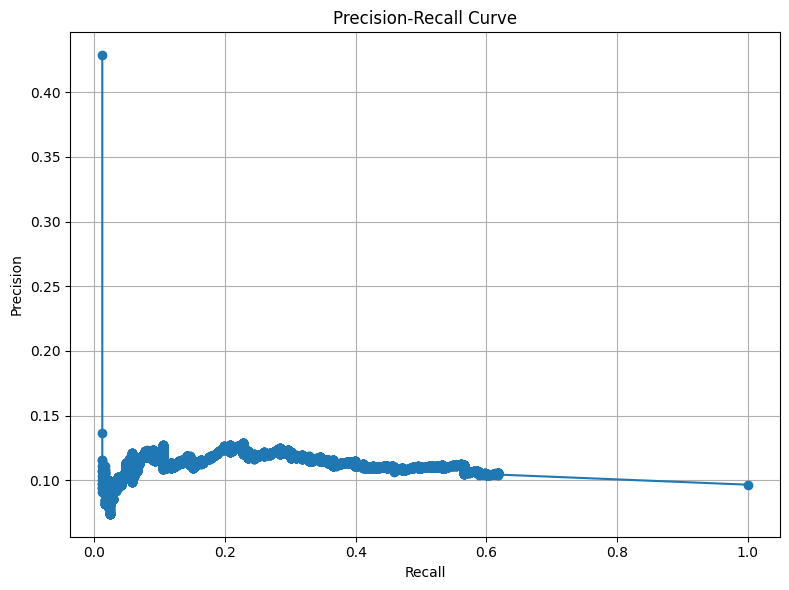

In [13]:
# Define the p-value thresholds
p_adj_thresholds = np.linspace(0.0000001, 1, 10000)

def get_curve(p_adj_thresholds, type):

    plt.figure(figsize=(8, 6))

    Yaxis = []
    Xaxis = []

    for thresh in p_adj_thresholds:
        confusion = get_confusion_sets(thresh, pair_to_p_adj)
        if type == "PR":
            y = get_precision(confusion)
            x = get_recall(confusion)
        elif type == "ROC":
            y = get_tp_rate(confusion)
            x = get_fp_rate(confusion)
        else:
            raise ValueError("Invalid type. Use 'PR' for Precision-Recall or 'ROC' for ROC curve.")
        
        if x is not None and y is not None:
            Yaxis.append(y)
            Xaxis.append(x)

    # Calculate AUC - but first make sure points are sorted by x-axis for correct calculation
    if len(Xaxis) > 0:
        # Sort the points by x-axis value
        sorted_indices = np.argsort(Xaxis)
        sorted_x = [Xaxis[i] for i in sorted_indices]
        sorted_y = [Yaxis[i] for i in sorted_indices]
        
        if type == "ROC":
            # For ROC curves, sklearn.metrics.auc works directly
            area = auc(sorted_x, sorted_y)
            print(f"Area Under ROC Curve (AUC-ROC): {area:.4f}")

        elif type == "PR":
            # For PR curves, we need to handle this differently
            # The x-axis (recall) might not be monotonically increasing
            # We need to use average precision or use trapezoid rule carefully
            area = auc(sorted_x, sorted_y)
            print(f"Area Under PR Curve (AUC-PR): {area:.4f}")

    plt.plot(Xaxis, Yaxis, marker='o')

    # Final plot adjustments
    if type == "PR":
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve")
    elif type == "ROC":
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

get_curve(p_adj_thresholds, "PR")

Area Under ROC Curve (AUC-ROC): 0.5392


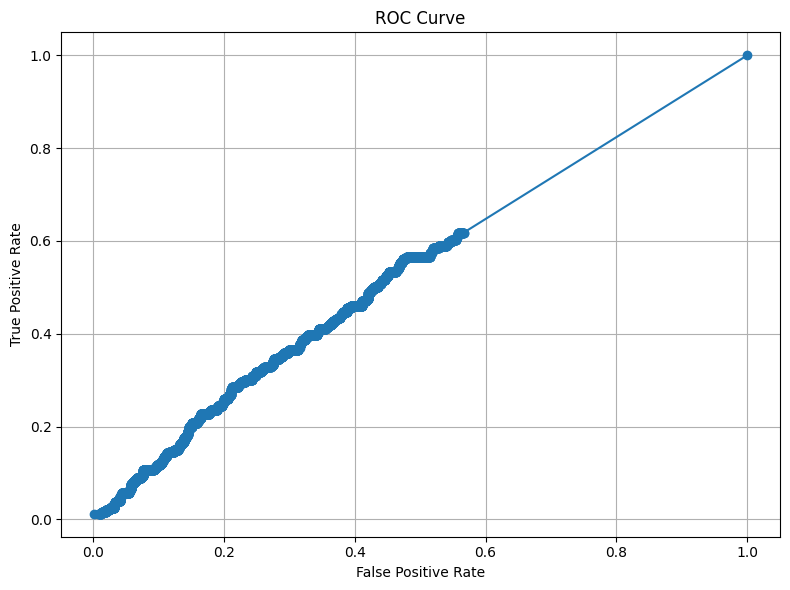

In [14]:
get_curve(p_adj_thresholds, "ROC")